# Regression Project with Various Models

This notebook presents a regression approach on a dataset using several models (SVR, linear regression, random forests, gradient boosting, etc.).  
We will:  
- Install and import the necessary libraries  
- Load and preprocess the data (encoding, standardization, etc.)  
- Separate features and the target variable (with logarithmic transformation)  
- Train and evaluate different models  
- Visualize the results (histograms, comparison tables)  
- Experiment with a subset of features  
- Implement an ensemble model for


In [1]:
!pip install pandas numpy scikit-learn matplotlib xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
    --------------------------------------- 1.6/124.9 MB 10.5 MB/s eta 0:00:12
   - -------------------------------------- 5.5/124.9 MB 15.2 MB/s eta 0:00:08
   -- ------------------------------------- 8.1/124.9 MB 14.4 MB/s eta 0:00:09
   --- ------------------------------------ 12.3/124.9 MB 15.7 MB/s eta 0:00:08
   ----- ---------------------------------- 17.6/124.9 MB 17.9 MB/s eta 0:00:07
   ------- -------------------------------- 22.5/124.9 MB 18.8 MB/s eta 0:00:06
   -------- ------------------------------- 27.5/124.9 MB 19.4 MB/s eta 0:00:06
   ---------- ----------------------------- 32.8/124.9 MB 20.0 MB/s eta 0:00:05
   ------------ --------------------------- 37.7/124.9 MB 20.3 MB/s eta 0:00:05
   ------------- -------------------------- 42.7/124.9 MB 20.6 MB/s eta 0:00:04
   --------------- ------------------------ 47.2/124.9 MB 20.9 MB/s eta 0:00:04
   ---------------- ----------------------- 51.1/124

## Importing Libraries

Here we import all the necessary libraries for data manipulation, modeling, and visualization.


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Models and validation tools
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb


## 1. Loading and Preprocessing Data

We start by loading the training and test datasets.  
- The `Id` column is removed from the training dataset (and from the test set when present).  
- The categorical variable `parentspecies` is encoded into dummy variables (one-hot encoding).  
- The columns are reindexed in alphabetical order to ensure consistency.


In [3]:
# Load datasets
training_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

# Remove 'Id' column from the training dataset
train = training_set.drop("Id", axis=1)

# Encode the categorical variable 'parentspecies'
train = pd.get_dummies(train, columns=["parentspecies"])
train = train.reindex(sorted(train.columns), axis=1)

# Prepare the test dataset: remove 'Id' and encode 'parentspecies'
testing = test_set.drop("Id", axis=1)
testing = pd.get_dummies(testing, columns=["parentspecies"])

# Standardize the test dataset (we will standardize the training set later)
sc_te = StandardScaler()
testing = pd.DataFrame(sc_te.fit_transform(testing), columns=testing.columns)


## 2. Feature Separation and Standardization

We separate the features (`X`) and the target variable (`pSat_Pa`).  
The target is transformed using log10 to normalize its distribution.  
Then, we standardize the features and ensure that the test set has the same columns as the training set.


In [4]:
# Separate features and target variable
x_train = train.drop("pSat_Pa", axis=1)
y_train = np.log10(train["pSat_Pa"])

# Standardize the training features
sc_trx = StandardScaler()
x_train = pd.DataFrame(sc_trx.fit_transform(x_train), columns=x_train.columns)

# Add missing columns to the test set (if necessary)
missing_columns = set(x_train.columns) - set(testing.columns)
for col in missing_columns:
    testing[col] = 0

# Reindex test columns in alphabetical order
testing = testing.reindex(sorted(testing.columns), axis=1)

# Display the shapes of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("testing shape:", testing.shape)


x_train shape: (27147, 31)
y_train shape: (27147,)
testing shape: (4490, 31)


## 3. Preview of Preprocessed Data

We display the first few rows of the processed datasets to verify preprocessing.


In [5]:
display(x_train.head())
display(y_train.head())
display(testing.head())


,C.C..non.aromatic.,C.C.C.O.in.non.aromatic.ring,MW,NumHBondDonors,NumOfAtoms,NumOfC,NumOfConf,NumOfConfUsed,NumOfN,NumOfO,...,nitro,nitroester,parentspecies_apin,parentspecies_apin_decane,parentspecies_apin_decane_toluene,parentspecies_apin_toluene,parentspecies_decane,parentspecies_decane_toluene,parentspecies_toluene,peroxide
0,-0.319537,-0.102264,-4.701921,-2.160675,-4.242272,-4.036712,-1.126867,-1.683251,-1.490005,-3.579190,...,-0.420714,-0.110639,-0.550751,-0.042087,52.093186,-0.03644,-0.299453,-0.008584,-1.437384,-0.623088
1,-0.319537,-0.102264,-3.799647,-2.160675,-3.860650,-4.036712,-1.126867,-1.683251,-0.085618,-2.777435,...,2.310303,-0.110639,-0.550751,-0.042087,-0.019196,-0.03644,-0.299453,-0.008584,0.695708,-0.623088
2,-0.319537,-0.102264,-3.238148,-2.160675,-3.479028,-3.347925,-1.121938,-1.615164,-0.085618,-2.376558,...,2.310303,-0.110639,-0.550751,-0.042087,-0.019196,-0.03644,-0.299453,-0.008584,0.695708,-0.623088
3,-0.319537,-0.102264,-2.917335,-1.179283,-3.288217,-3.347925,-1.117010,-1.683251,-0.085618,-1.975681,...,2.310303,-0.110639,-0.550751,-0.042087,-0.019196,-0.03644,-0.299453,-0.008584,0.695708,-0.623088
4,-0.319537,-0.102264,-2.596522,-1.179283,-3.097406,-3.347925,-1.117010,-1.547076,-0.085618,-1.574803,...,2.310303,-0.110639,-0.550751,-0.042087,-0.019196,-0.03644,-0.299453,-0.008584,0.695708,-0.623088


0    5.807518
1    4.012656
2    4.130899
3    2.383151
4    2.498802
Name: pSat_Pa, dtype: float64

,C.C..non.aromatic.,C.C.C.O.in.non.aromatic.ring,MW,NumHBondDonors,NumOfAtoms,NumOfC,NumOfConf,NumOfConfUsed,NumOfN,NumOfO,...,nitro,nitroester,parentspecies_apin,parentspecies_apin_decane,parentspecies_apin_decane_toluene,parentspecies_apin_toluene,parentspecies_decane,parentspecies_decane_toluene,parentspecies_toluene,peroxide
0,-0.2728,-0.098197,-3.045651,-1.226763,-3.332799,-2.817605,-1.068595,-1.358076,-1.337891,-2.012763,...,-0.402913,-0.087351,-0.506256,-0.03658,-0.025857,-0.044816,-0.246909,0,0.616312,-0.754937
1,-0.2728,-0.098197,1.455262,-1.226763,0.408372,-0.583096,-0.216768,1.118647,1.508416,1.681462,...,-0.402913,-0.087351,-0.506256,-0.03658,-0.025857,-0.044816,-0.246909,0,0.616312,1.324614
2,-0.2728,-0.098197,0.818864,-0.392192,0.408372,-0.583096,0.249075,1.118647,1.508416,0.860523,...,-0.402913,-0.087351,-0.506256,-0.03658,-0.025857,-0.044816,-0.246909,0,0.616312,-0.754937
3,-0.2728,-0.098197,-0.220285,-0.392192,0.824058,0.906577,0.027245,-0.188512,0.085262,-0.781354,...,-0.402913,-0.087351,1.975284,-0.03658,-0.025857,-0.044816,-0.246909,0,-1.622555,-0.754937
4,-0.2728,-0.098197,-1.430940,0.442378,-0.630842,-0.583096,-0.247824,1.118647,-1.337891,-1.191824,...,-0.402913,-0.087351,-0.506256,-0.03658,-0.025857,-0.044816,-0.246909,0,0.616312,-0.754937


## 4. Training the SVR Model

We train an SVR model (with an RBF kernel) on the standardized data.  
Next, we make predictions on the test set and save the results to a CSV file.


In [6]:
# Train the SVR model
svr = SVR(kernel="rbf")
svr.fit(x_train, y_train)

# Make predictions on the test set
preds = svr.predict(testing)

# Prepare and save the results
results = pd.DataFrame({
    'Id': test_set['Id'],
    'target': np.log10(np.abs(preds))  # log10 transformation of absolute prediction values
})
results.to_csv("results.csv", index=False)
print(results.head())


        Id    target
0  1000001  0.167269
1  1000002  0.099725
2  1000003  0.243104
3  1000004  0.534321
4  1000005  0.622745


## 5. Model Evaluation with Cross-Validation

We evaluate the SVR model using 2-fold cross-validation with the R² scoring metric.


In [7]:
scores = cross_val_score(svr, x_train, y_train, cv=2, scoring="r2")
print("Mean R^2 score from cross-validation:", scores.mean())


Mean R^2 score from cross-validation: 0.6870475701923686


## 6. Visualization of Predictions

We create a histogram of the distribution of predictions (after log10 transformation) to observe their spread.


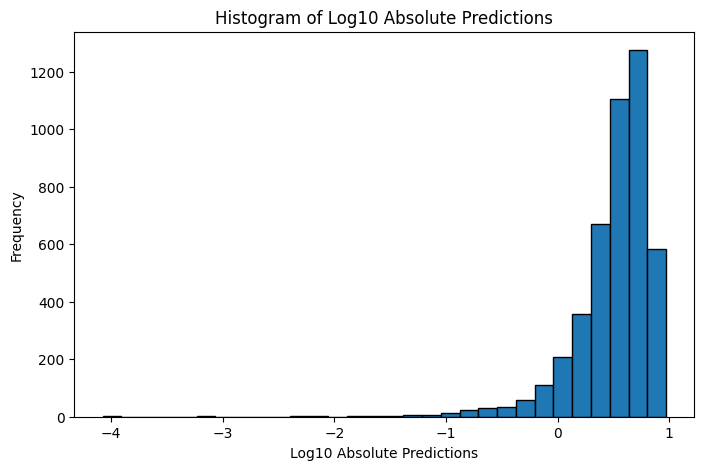

In [8]:
plt.figure(figsize=(8, 5))
plt.hist(np.log10(np.abs(preds)), bins=30, edgecolor='black')
plt.title('Histogram of Log10 Absolute Predictions')
plt.xlabel('Log10 Absolute Predictions')
plt.ylabel('Frequency')
plt.show()


## 7. Comparing Different Models

We compare the performance (R² score in cross-validation) of different models:  
- Linear Regression  
- Polynomial Regression (degree 3)  
- Random Forest  
- SVR  
- Gradient Boosting Regressor


In [9]:
# Dictionary to store scores
model_comparison = {
    "model": ["Linear", "Polynomial", "RandomForest", "SVR", "GradientBoostRegressor"],
    "CV_R2": [0] * 5
}

# Linear Regression
lin_reg = LinearRegression()
model_comparison["CV_R2"][0] = cross_val_score(lin_reg, x_train, y_train, cv=2, scoring="r2").mean()

# Polynomial Regression (degree 3)
poly_features = PolynomialFeatures(degree=3)
x_poly = poly_features.fit_transform(x_train)
lin_reg_poly = LinearRegression()
model_comparison["CV_R2"][1] = cross_val_score(lin_reg_poly, x_poly, y_train, cv=2, scoring="r2").mean()

# Random Forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=0)
model_comparison["CV_R2"][2] = cross_val_score(rf_reg, x_train, y_train, cv=2, scoring="r2").mean()

# SVR
svr_reg = SVR(kernel="rbf")
model_comparison["CV_R2"][3] = cross_val_score(svr_reg, x_train, y_train, cv=2, scoring="r2").mean()

# Gradient Boosting Regressor
gb_reg = GradientBoostingRegressor(random_state=0)
model_comparison["CV_R2"][4] = cross_val_score(gb_reg, x_train, y_train, cv=2, scoring="r2").mean()

# Convert to DataFrame and display
losses = pd.DataFrame(model_comparison)
print(losses)


                    model       CV_R2
0                  Linear    0.642179
1              Polynomial -449.856002
2            RandomForest    0.658659
3                     SVR    0.687048
4  GradientBoostRegressor    0.681251


## 8. Visualization of the Comparison Table

We display the comparison table of scores using a graphical representation.


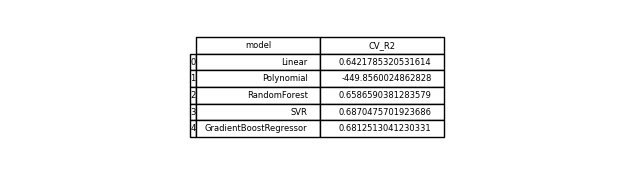

In [10]:
from pandas.plotting import table

fig, ax = plt.subplots(figsize=(8, 2))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
table(ax, losses, loc='center', colWidths=[0.2]*len(losses.columns))
plt.show()


## 9. SVR Model with a Subset of Features

Here we test the impact of excluding certain features (`nitroester`, `MW`, `carbonylperoxynitrate`, `C.C.C.O.in.non.aromatic.ring`, `aromatic.hydroxyl`) on the SVR model.


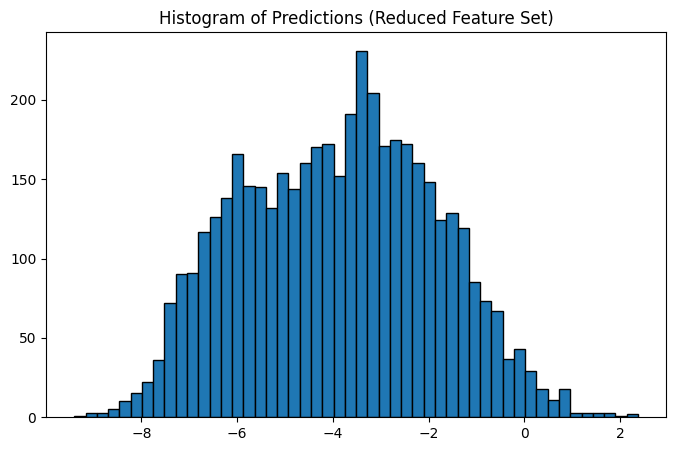

In [11]:
# List of columns to drop
drop_columns = ['nitroester', 'MW', 'carbonylperoxynitrate', 
                'C.C.C.O.in.non.aromatic.ring', 'aromatic.hydroxyl']

# Create reduced datasets for training and testing
train_x_reduced = x_train.drop(drop_columns, axis=1)
testing_reduced = testing.drop(drop_columns, axis=1)

# Train the SVR model on the reduced dataset
svr_reduced = SVR()
svr_reduced.fit(train_x_reduced, y_train)
pred_reduced = svr_reduced.predict(testing_reduced)

# Save the reduced model results
results_reduced = pd.DataFrame({
    "Id": test_set["Id"],
    "target": pred_reduced
})
results_reduced.to_csv("results_reduced.csv", index=False)

# Histogram of reduced model predictions
plt.figure(figsize=(8, 5))
plt.hist(results_reduced['target'], bins=50, edgecolor='black')
plt.title("Histogram of Predictions (Reduced Feature Set)")
plt.show()


## 10. Ensemble Modeling

In this section, we use an ensemble of models (linear regression, SVR, XGBoost, random forest, gradient boosting) to make final predictions.  
We will load the data (located in the `data` folder), perform encoding, standardization, and split into training and validation sets, then combine the predictions from different models.


In [14]:
# Load datasets for ensemble modeling (path different, located in "data" folder)
train_ensemble = pd.read_csv('train.csv')
test_ensemble = pd.read_csv('test.csv')

# Encode 'parentspecies'
train_encoded = pd.get_dummies(train_ensemble, columns=['parentspecies'], drop_first=True)
test_encoded = pd.get_dummies(test_ensemble, columns=['parentspecies'], drop_first=True)

# Align the test dataset with the training dataset columns
for column in train_encoded.columns:
    if column not in test_encoded.columns and column not in ['pSat_Pa']:
        test_encoded[column] = 0

# Transform the target variable using log10
train_encoded['pSat_Pa_log'] = np.log10(train_ensemble['pSat_Pa'])

# Select features, excluding specific columns
drop_features = ['Id', 'pSat_Pa', 'pSat_Pa_log', 'nitroester', 'MW', 
                 'carbonylperoxynitrate', 'C.C.C.O.in.non.aromatic.ring', 'aromatic.hydroxyl']
X = train_encoded.drop(drop_features, axis=1)
y = train_encoded['pSat_Pa_log']

# Prepare the test dataset with the same features
X_test = test_encoded.drop('Id', axis=1)
X_test = X_test[X.columns]

# Split the training dataset into training and validation sets
X_train, X_val, y_train_val, y_val = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


## 11. Training Models for the Ensemble

We train several models on the reduced training set (after standardization):  
- Linear Regression  
- SVR  
- XGBoost  
- Random Forest  
- Gradient Boosting  

Their predictions will then be combined to obtain the ensemble prediction.


In [15]:
# Initialize models
lin_model = LinearRegression()
svr_model = SVR(kernel='rbf')
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=1)
rf_model = RandomForestRegressor(n_estimators=100, random_state=1)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=1)

# Train models on the training set
lin_model.fit(X_train_scaled, y_train_val)
svr_model.fit(X_train_scaled, y_train_val)
xgb_model.fit(X_train_scaled, y_train_val)
rf_model.fit(X_train_scaled, y_train_val)
gb_model.fit(X_train_scaled, y_train_val)


GradientBoostingRegressor(random_state=1)

## 12. Evaluating the Ensemble

We compute the ensemble prediction (average of each model’s predictions) on the validation set and evaluate its performance (R² and MSE).


In [16]:
# Predictions on the validation set by each model
ensemble_val_preds = (lin_model.predict(X_val_scaled) + 
                      svr_model.predict(X_val_scaled) +
                      xgb_model.predict(X_val_scaled) +
                      rf_model.predict(X_val_scaled) +
                      gb_model.predict(X_val_scaled)) / 5

# Compute metrics
r2_ensemble = r2_score(y_val, ensemble_val_preds)
mse_ensemble = mean_squared_error(y_val, ensemble_val_preds)

print(f"Ensemble R2 Score on the validation set: {r2_ensemble}")
print(f"Ensemble MSE on the validation set: {mse_ensemble}")


Ensemble R2 Score on the validation set: 0.7532692872247267
Ensemble MSE on the validation set: 1.109703270283877


## 13. Final Predictions with the Ensemble

We generate the final predictions on the test set by combining the predictions from each model and save the results to a CSV file.


In [17]:
# Predictions on the test set by each model
test_pred_lin = lin_model.predict(X_test_scaled)
test_pred_svr = svr_model.predict(X_test_scaled)
test_pred_xgb = xgb_model.predict(X_test_scaled)
test_pred_rf = rf_model.predict(X_test_scaled)
test_pred_gb = gb_model.predict(X_test_scaled)

# Compute ensemble prediction (average)
ensemble_test_preds = (test_pred_lin + test_pred_svr + test_pred_xgb + test_pred_rf + test_pred_gb) / 5

# Prepare and save final results
ensemble_results = pd.DataFrame({
    'Id': test_ensemble['Id'],
    'target': ensemble_test_preds
})
ensemble_results.to_csv("test_results_ensemble.csv", index=False)
